Calculate Kuiper metric for a given cadence for each point of the sky.

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
from tqdm.notebook import tqdm

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

from simcodes.fitters import ExtendedLS
from gatspy.periodic import LombScargleMultiband
from KuiperMetric import KuiperVS

In [2]:
# Grab the current baseline file. Should have been downloaded with rubin_sim. 
# Can grab lots of different sims from: http://astro-lsst-01.astro.washington.edu:8081/
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
conn = maf.db.OpsimDatabase(baseline_file)
outDir = 'temp'
resultsDb = maf.db.ResultsDb(outDir=outDir)

In [3]:
# Same for rolling cadence
rollDbFile = '/home/alex/rubin_sim_data/rolling_all_sky_ns2_rw0.9_v2.0_10yrs.db'
rollName = os.path.split(rollDbFile)[-1].replace('.db', '')
rollDb = maf.db.OpsimDatabase(rollDbFile)
resultsDbRoll = maf.db.ResultsDb(outDir=outDir)
print(rollName)

rolling_all_sky_ns2_rw0.9_v2.0_10yrs


In [4]:
pointKuipValues5years=pd.read_csv('pointKuipValues5years.csv')
pointKuipValues5years.head()

,periods,kuipMetricBaseline,kuipMetricRolling
0,8.82,0.063992,0.060913
1,10.09,0.077100,0.071225
2,23.91,0.092395,0.084018
3,26.85,0.082317,0.064977
4,34.40,0.072232,0.060084


In [5]:
ra = [0.]
dec = [-20]
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)

metricPass = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
bundleListPass=[]

bundleListPass.append(maf.MetricBundle(metricPass, slicer, sql, runName='PassForAPoint'))
bdPass = maf.metricBundles.makeBundlesDictFromList(bundleListPass)
bgPass = maf.metricBundles.MetricBundleGroup(bdPass, conn, 
                                                outDir=outDir, resultsDb=resultsDb)
bgPass.runAll()

Querying database observations with no constraint for columns ['fiveSigmaDepth', 'rotSkyPos', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD'].
Found 2086980 visits
Running:  ['PassForAPoint_Pass_filter_observationStartMJD_fiveSigmaDepth_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [6]:
def phasedCadence(period:float,dataSlice,mjdCol:str='observationStartMJD'):
    """
    Returns phase values for the timestamps of observatons
    """
    return (dataSlice[mjdCol]%float(period)/float(period))

In [8]:
### Integrating with period determination
library=pd.read_csv('simcodes/ZTF_VS_all_formatted.csv',index_col=0)
library['unique_filts_']=library['unique_filts_'].apply(lambda x:list(map(eval,x[1:-1].split(' '))))
library['ymean_by_filt_']=library['ymean_by_filt_'].apply(lambda x:np.array([float(k) for k in x[1:-1].split(' ') if len(k)>0]))
library['theta']=library['theta'].apply(lambda x:np.array([float(k) for k in x[1:-1].split(' ') if len(k)>0]))

In [9]:
library.head()

,_best_period,unique_filts_,ymean_by_filt_,omega,theta,source_id,Expected,E-C,Type,Subtype,Nterms
0,0.236720,"[zg, zi]","[21.48676699, 18.7078934]",26.542730,"[0.00513976, 0.21720297, 0.09356054, -0.013740...",2163969347391329408,0.538431,0.301711,RR,fundamental mode,1
1,113.361706,"[zg, zr]","[19.47585281, 15.9530296]",0.055426,"[0.07714091, -0.18145219, 0.02491756, -0.07214...",4068080700794544000,146.171133,32.809427,MIRA_SR,Mira or Semiregular,1
2,70.461748,"[zg, zr]","[19.31496061, 15.94673461]",0.089172,"[0.19851974, -0.20921135, -0.20103493, -0.0867...",4068074069364824064,72.297616,1.835867,MIRA_SR,Mira or Semiregular,1
3,0.664768,"[zi, zr]","[19.2131386, 20.28765675]",9.451700,"[0.04120764, -0.01789527, 0.21846307, 0.025405...",2167254550695165056,0.698121,0.033353,RR,fundamental mode,1
4,0.555125,"[zg, zr]","[16.75914552, 16.15382336]",11.318498,"[0.06246225, 0.35994573, -0.28540377, -0.01781...",146608674289675264,0.555147,0.000021,RR,fundamental mode,1


In [21]:
def determinePeriod(dataSlice,row,plot:bool,periodMin:float=None, periodMax:float=None)->float:
    """
    Determine period for a simulated light curve 'observed' with a given cadence. Credits for the simcode and 
    LCs to Kresimir Tisanic
    """
    uniqueFilts=[s.strip('z') for s in row['unique_filts_']]
    dataSlice=dataSlice[np.isin(dataSlice['filter'], uniqueFilts)]
    t=dataSlice['observationStartMJD']
    filts=dataSlice['filter']
    ext=ExtendedLS(fit_period=True,optimizer_kwds=dict(quiet=True),Nterms_base=row['Nterms'])
    ext.import_parameters(row)
    mags = ext.predict(t=t,filts=filts)
    magErrs=0.1*mags
    
    if periodMin==None:
        periodMin=row['_best_period']*0.1
    if periodMax==None:
        periodMax=row['_best_period']*5
    
    ext.optimizer.period_range = (periodMin, periodMax)
    p=ext.fit(t,mags,magErrs,filts).best_period
    if plot==True:
        fig=plt.figure(figsize=(5,5))
        subplot=fig.add_subplot(1,1,1)
        for f in uniqueFilts:
            subplot.scatter((t[np.where(filts==f)]%p)/p,mags[np.where(filts==f)],s=1,label=f)
        subplot.legend()
    return p

In [23]:
import dask.dataframe as dd
from dask.multiprocessing import get

In [26]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [28]:
plot=False
tqdm.pandas()

dataSlice=bundleListPass[0].metricValues.data[~bundleListPass[0].metricValues.mask][0]
print('dataSlice size is '+str(len(dataSlice)))
libraryObsQuality=library.copy(deep=True)
libraryObsQuality=libraryObsQuality.sample(n=3)
dLibraryObsQuality = dd.from_pandas(libraryObsQuality, npartitions=60)

#res = dLibraryObsQuality.map_partitions(lambda df: df.apply((lambda row:determinePeriod(dataSlice,*row,plot=plot), 
#                                                             axis=1)).compute(get=get)

libraryObsQuality['detectedPeriod']=dLibraryObsQuality.apply(lambda row:determinePeriod(dataSlice,row,
                                                                                       plot=plot), 
                                                                                       axis=1,meta=('x', 'f8'))

#libraryObsQuality['detectedPeriod']=libraryObsQuality.progress_apply(lambda row:determinePeriod(dataSlice,row,
#                                                                                       plot=plot), 
#                                                                                       axis=1)
libraryObsQuality['diffPeriod']=libraryObsQuality['_best_period']-libraryObsQuality['detectedPeriod']
libraryObsQuality['relativeDiff']=libraryObsQuality['diffPeriod']*100/libraryObsQuality['_best_period']


dataSlice size is 851
[                                        ] | 0% Completed | 36min 59.3s


KeyboardInterrupt: 

In [18]:
kuipHpidLists['kuipRand'][kuipHpidLists['kuipRand']['kuipValue']>0.3]

,hpid,kuipValue
174,3302,0.338808
471,4088,0.343041
1468,5337,0.325855
781,4575,0.343775
1,2524,0.571711
1473,5342,0.320769
6812,10701,0.342619
2868,6757,0.346422
3764,7653,0.332899
6456,10345,0.366858


In [19]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [20]:
# An ugly hack to get an internal id of an hpix by its global map hpid. To do: make it less ugly
idxs={l.runName:i for i,l in enumerate(bundleListKuipByHPix)}

In [21]:
idxs['12102']

40

In [38]:
# See LCs with periods in a range that we investigate right now (meaning: the range close to the period
# used for calculating the Kuiper value)
library[(library['_best_period']>0.48) & (library['_best_period']<0.51)]

,_best_period,unique_filts_,ymean_by_filt_,omega,theta,source_id,Expected,E-C,Type,Subtype,Nterms,detectedPeriod
52,0.503685,[zr],[16.44935035],12.474437,"[0.165414422, -0.208396413, -0.00837025178, 4....",4072920858405481600,0.601972,0.098287,RR,fundamental mode,1,None
153,0.484194,"[zg, zr]","[18.86312737, 17.51511101]",12.976576,"[0.18104185, -0.23652352, 0.38562217, -0.05016...",4116498318147631232,0.484063,-0.000132,RR,fundamental mode,1,None
169,0.506052,"[zg, zr]","[18.5426503, 17.65873161]",12.416078,"[0.11387188, -0.16286197, -0.41692642, 0.14988...",4116960005660630272,0.506013,-0.000039,RR,fundamental mode,1,None
182,0.499373,"[zg, zi]","[19.44978421, 18.6683998]",12.582153,"[-0.14081325, -0.21003245, 0.05783711, 0.01183...",899283417829343744,0.584581,0.085208,RR,fundamental mode,1,None
184,0.507698,"[zg, zr]","[16.96715793, 16.43185216]",12.375823,"[0.05572377, 0.27347325, 0.28841492, 0.0818993...",4089378279751765120,0.446090,-0.061608,RR,fundamental mode,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...
100186,0.490399,"[zg, zi, zr]","[17.16617467, 16.70437024, 16.72978159]",12.812403,"[0.09674357, 0.34216595, -0.11003756, -0.02856...",4587477800342119936,0.490419,0.000020,RR,fundamental mode,5,None
100195,0.488861,"[zg, zi, zr]","[15.52408957, 15.34782036, 15.36170137]",12.852709,"[0.04272845, 0.06930996, 0.36468655, 0.06861, ...",2094733688604844160,0.488859,-0.000002,RR,fundamental mode,5,None
100215,0.504569,"[zg, zi, zr]","[17.78120344, 17.64699824, 17.66612978]",12.452581,"[0.1289967, -0.28893133, -0.21536774, -0.14693...",2150995797377659520,0.504573,0.000004,RR,fundamental mode,5,None
100245,0.502045,"[zg, zi, zr]","[17.29055838, 17.18311403, 17.2625457]",12.515177,"[0.10941777, -0.34293055, 0.14051259, -0.01039...",1330949101617006208,0.502056,0.000011,RR,fundamental mode,5,None


dataSlice size is 139


  0%|          | 0/3 [00:00<?, ?it/s]

,_best_period,unique_filts_,ymean_by_filt_,omega,theta,source_id,Expected,E-C,Type,Subtype,Nterms,detectedPeriod,diffPeriod
66830,0.300477,"[zg, zi, zr]","[17.93485495, 18.029099, 17.91590579]",20.910694,"[0.03217458, -0.02050232, -0.22016727, 0.05825...",1330968484805660800,0.300477,-2.202420e-07,RR,first-overtone,3,0.300477,2.077804e-08
66831,0.513792,"[zg, zi, zr]","[15.77307136, 15.66097248, 15.68973543]",12.229043,"[0.03272435, -0.05519261, 0.36533793, 0.165579...",1339570548385963264,0.513797,5.339388e-06,RR,fundamental mode,3,0.513792,6.009662e-08
66832,0.513275,"[zg, zi, zr]","[16.32447846, 16.16658193, 16.21301425]",12.241371,"[0.04096444, 0.19689812, -0.30353544, 0.158969...",1339434896138382592,0.513265,-9.755336e-06,RR,fundamental mode,3,0.513275,-3.934636e-08


<Figure size 216x144 with 0 Axes>

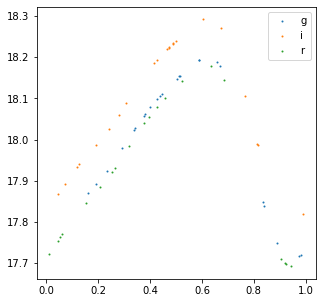

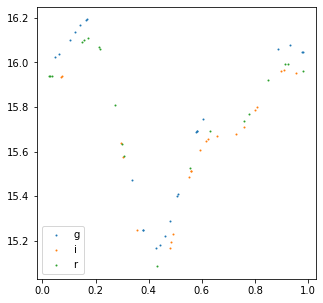

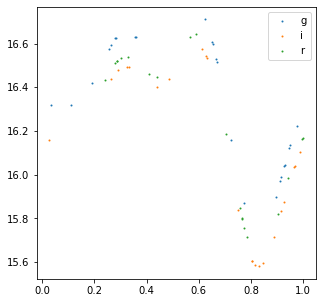

In [30]:
lib=library[66830:66833]
getLCsFromHPix(bundleListKuipByHPix,idx=40,library=lib,periodMin=0.1, periodMax=10)